# Model Training and Testing

In this file, we train each of our models on the exact same training dataset, and test them
on the same testing dataset. This allows us to judge their performance, strengths, and
weaknesses using a comparable measure. We hope that this will, in conjunction with our
hypotheses, help us understand the merits of each model, and be more informed in future
instances of model selection.

In [1]:
print("HI")

HI


## Imports

In [59]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support as class_metrics
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import pickle

## Create the Dataset

First, we separate out the testing and training dataset for each of our models to train on.
In this case, we decided against k-cross validation due to the sheer size of our dataset.
The accuracy of our models should be representative of their performance on future data as
well, since there is such a large quantity of training data.

Our dataset does have a few issues: several of the variables have classes which occur very infrequently.
This may bias our results, since we don't know much about how that variable affects heart disease relative to the other
classes. Therefore, we may need to stratify our data to get more accurate results.
Additionally, the columns **GenHealth** and **Stroke** have the potential to bias our results.
These factors are much more likely to occur due to heart disease, but may not be a good predictor
of its future fruition. Therefore, to deal with each of these issues, we will make separate versions of our dataset for
each of these cases: **Normal**, **Stratified**, and **No Health Indicators**.

In [3]:
# Import the dataset
data = pd.read_csv('../data/raw_data.csv')

# Create a lists of each type of feature
nominal_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'Race', 'Diabetic',
                  'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']
ordinal_features = ['AgeCategory', 'GenHealth']
continuous_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

# region Convert the nominal features into one-hot encodings

# Create a One-Hot Encoder
encoder = OneHotEncoder()

# For each nominal feature...
for feature in nominal_features:

    # Get an encoded version
    encoded_feature = pd.DataFrame(encoder.fit_transform(data[[feature]]).toarray(),
                                   columns=[f'{feature}_{f_class}' for f_class in data[feature].unique()])

    # Remove the old feature from the data
    data = data.drop(feature, axis=1)

    # Add the encoded feature to the data
    data = data.join(encoded_feature)

# endregion Convert the nominal features into one-hot encodings

# region Convert the ordinal features into labels

# For each nominal feature...
for feature in ordinal_features:

    # Replace the old feature with an encoded feature
    data[feature] = data[feature].astype('category').cat.codes

# endregion Convert the ordinal features into labels

# Convert the output column to be numerical
data['HeartDisease'] = data['HeartDisease'].astype('category').cat.codes

# Get the X and y of the dataset
data_X = data.iloc[:,1:]
data_y = data.loc[:,'HeartDisease']

# Display the head of the data
data.head()
print("Rows:    ", data.shape[0])
print("Columns: ", data.shape[1])

Rows:     319795
Columns:  35


In [4]:
# Get the Normal test-train split
normal_train_X, normal_test_X, normal_train_y, normal_test_y = train_test_split(data_X, data_y, train_size=2/3,
                                                                                random_state=42)

# Get the Stratified test-train split
stratified_train_X, stratified_test_X, stratified_train_y, stratified_test_y = train_test_split(data_X, data_y,
                                                                                                train_size=2/3,
                                                                                                stratify=data_y,
                                                                                                random_state=42)
# Get the No Health test-train split
dropped_features = [feature for feature in data.columns if ('GenHealth' in feature or 'Stroke' in feature) and feature in data_X.columns]
nohealth_train_X, nohealth_test_X, nohealth_train_y, nohealth_test_y = train_test_split(data_X.drop(dropped_features,
                                                                                                    axis=1),
                                                                                        data_y, train_size=2/3,
                                                                                        random_state=42)

## Dataset Tuning

Now that we know have our datasets, we need to find which we want to use. To do that, we can introduce a simple model
which we will use as a measure. By comparing the results of the model trained on each of the different datasets, we
can get a sense of how the changes impact performance, and potentially help us intuit whether any bias is introduced by
our data. In specific, we are looking to see if the dropped data columns or the stratification make the dataset perform
better or worse.

The model we will be using for this is **Logistic Regression**, since this model is very simple and fast to train.

In [5]:
# Create a standard scalar and one-hot-encoding pipeline for each dataset
normal_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])
stratified_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])
nohealth_pipe = Pipeline([('scalar', StandardScaler()), ('lr', LogisticRegression())])

# Train each logistic regression on its dataset
normal_pipe.fit(normal_train_X, normal_train_y)
stratified_pipe.fit(stratified_train_X, stratified_train_y)
nohealth_pipe.fit(nohealth_train_X, nohealth_train_y)

# Make predictions with each logistic regression
normal_prediction = normal_pipe.predict(normal_test_X)
stratified_prediction = stratified_pipe.predict(stratified_test_X)
nohealth_prediction = nohealth_pipe.predict(nohealth_test_X)

# Find the score of each regression
normal_precision, normal_recall, normal_f, _ = class_metrics(normal_test_y, normal_prediction)
stratified_precision, stratified_recall, stratified_f, _ = class_metrics(stratified_test_y, stratified_prediction)
nohealth_precision, nohealth_recall, nohealth_f, _ = class_metrics(nohealth_test_y, nohealth_prediction)

# Display the score of each regression
print("Normal Dataset LR:")
print(f"Precision: {normal_precision[1]}")
print(f"Recall:    {normal_recall[1]}")
print(f"F1 Score:  {normal_f[1]}")
print()
print("Stratified Dataset LR:")
print(f"Precision: {stratified_precision[1]}")
print(f"Recall:    {stratified_recall[1]}")
print(f"F1 Score:  {stratified_f[1]}")
print()
print("No Health Dataset LR:")
print(f"Precision: {nohealth_precision[1]}")
print(f"Recall:    {nohealth_recall[1]}")
print(f"F1 Score:  {nohealth_f[1]}")

Normal Dataset LR:
Precision: 0.5112219451371571
Recall:    0.08886962176221957
F1 Score:  0.15141722832610102

Stratified Dataset LR:
Precision: 0.5166767738023045
Recall:    0.0933800964489259
F1 Score:  0.15817321080478977

No Health Dataset LR:
Precision: 0.4827018121911038
Recall:    0.06350926628373252
F1 Score:  0.11224978450340006


As we can see, the stratified dataset performed marginally better than the normal dataset, whereas the No Health
indicators dataset performed moderately worse. If were really trying to predict heart disease, this would indicate to
us that using these columns may be unhelpful for our predictions. However, since that is not the case and since we have
the data, we are going to use it anyways, and keep with the stratified dataset.

However, some of our models may need a smaller subset of the data, such as the Gaussian Process Classifier. This is
because they have high memory demands which scale with the data.

Below, let's do two things: Relabel the stratified dataset we'll be using to be more simple, and create a subset of that
dataset for models which need less data

In [6]:
# Rename the stratified dataset
train_X, test_X, train_y, test_y = stratified_train_X, stratified_test_X, stratified_train_y, stratified_test_y

# Get a smaller subset of the dataset
data_subset = data.sample(5000, random_state=42)
data_sub_X = data_subset.iloc[:,1:]
data_sub_y = data_subset.loc[:,'HeartDisease']

# Get the Stratified test-train split
train_sub_X, test_sub_X, train_sub_y, test_sub_y = train_test_split(data_sub_X, data_sub_y, train_size=2/3,
                                                                    stratify=data_sub_y, random_state=42)

# Model Training

Now, we need to train each of our models on the stratified data. Since our training dataset is so large (around
200,000 samples), we do not need to cross validate our results for each model - they should be representative of true
performance relative to one another.

Let's start by defining some methods that makes sure that each of our models is trained the same general way.

In [62]:
def train_model(model, parameter_dict, dataset_train_x, dataset_train_y):
    """This function is used to the find the best model using Cross Validating grid search.
    It also applies a standard scaling pipeline to the data.

    :param model: An SK Learn model to train
    :param parameter_dict: A dictionary of parameters to optimize using grid search. Keys are non-pipe parameters.
    :param dataset_train_x: The X values of the training dataset
    :param dataset_train_y: The y values of the training dataset
    :return best_model: The best model found by the grid search, retrained on all of the data
    :return search: The grid search object
    """

    # Create the pipeline
    pipe = Pipeline([('scalar', StandardScaler()), ('model', model)])

    # Find the parameter grid
    parameter_grid = {'model__' + param: parameter_dict[param] for param in parameter_dict}

    # Get the GridSearch object
    search = GridSearchCV(pipe, parameter_grid, cv=3, n_jobs=-1, verbose=100, scoring='f1')

    # Search for the best model
    search.fit(dataset_train_x, dataset_train_y)

    # Train the best model found
    best_model = Pipeline([('scalar', StandardScaler()), ('model', model)]).set_params(**search.best_params_)
    best_model.fit(dataset_train_x, dataset_train_y)

    # Return the grid search object
    return best_model, search


def display_results(model_name, best_model, grid_search, dataset_train_x, dataset_train_y,
                    dataset_test_x, dataset_test_y):
    """This function displays the results of the grid search both via tables and graphically.

    :param model_name: The name of the SK Learn model trained
    :param best_model: The best model found by the grid search
    :param grid_search: The grid search object which optimized the model
    :param dataset_train_x: The X values of the training dataset
    :param dataset_train_y: The y values of the training dataset
    :param dataset_test_x: The X values of the training dataset
    :param dataset_test_y: The y values of the training dataset
    """

    # Add spacing
    print("\n")

    # Start by displaying the trend of the data over each of the parameters
    for param in grid_search.best_params_:

        # This dict stores the mean performance for each parameter
        param_dict = {}

        # For the parameter value for each grid search iteration
        for p_ind, p in enumerate(grid_search.cv_results_[f'param_{param}']):

            # Get P's name
            pname = str(p)

            # If the parameter is not in the param dictionary, add it
            if pname not in param_dict: param_dict[pname] = (1, grid_search.cv_results_['mean_test_score'][p_ind])

            # Otherwise, summate them
            else: param_dict[pname] = (param_dict[pname][0] + 1,
                                   param_dict[pname][1] + grid_search.cv_results_['mean_test_score'][p_ind])

        # Finally, find the average value for each parameter value across all grid search iteration
        for p in param_dict:
            pname = str(p)
            param_dict[pname] = param_dict[pname][1] / param_dict[pname][0]

        # If the data is numeric, draw a lineplot
        if type(list(param_dict.keys())[0]) is not str:
            xtick_enum = range(len(list(param_dict.keys())))
            ax = sns.lineplot(x=xtick_enum, y=param_dict.values())
            ax.set_xticks(xtick_enum, list(param_dict.keys()))

        # otherwise, draw a barplot
        else: ax = sns.barplot(x=list(param_dict.keys()), y=list(param_dict.values()))

        # Since we only care about the differences between models, zoom in the plot to see the differences
        max_val = max(param_dict.values())
        min_val = min(param_dict.values())
        range_val = max_val - min_val
        plt.ylim(min_val - range_val*0.1, max_val + range_val*0.1)

        # Add plot aesthetics
        ax.set_xlabel(param[7:].capitalize() + ' Value')
        ax.set_ylabel('F1 Score')
        plt.title(f'F1 Score over {param[7:].capitalize()} Value')
        plt.show()

    # Calculate the performance of the best model
    model_train_pred = best_model.predict(dataset_train_x)
    model_test_pred = best_model.predict(dataset_test_x)

    # Calculate the performance metrics of the best model
    model_train_precision, model_train_recall, model_train_f1, _ = class_metrics(dataset_train_y, model_train_pred,
                                                                                 zero_division=0)
    model_test_precision, model_test_recall, model_test_f1, _ = class_metrics(dataset_test_y, model_test_pred,
                                                                              zero_division=0)

    # Display which parameters were best
    print("The best parameters were:")
    for param in grid_search.best_params_:
        print(re.search(r'model__(.*)', param).group(1) + f": {grid_search.best_params_[param]}")
    print("\n")

    # Display the scores of the best model
    print(f"{model_name.title()} Prediction Metrics:")
    print(f"Train Precision: {model_train_precision[1]}")
    print(f"Train Recall:    {model_train_recall[1]}")
    print(f"Train F1 Score:  {model_train_f1[1]}")
    print(f"Test Precision:  {model_test_precision[1]}")
    print(f"Test Recall:     {model_test_recall[1]}")
    print(f"Test F1 Score:   {model_test_f1[1]}")


def save_model(model_name, grid_search):
    """Save the best model's parameters.

    :param model_name: The name of the SK Learn model trained
    :param grid_search: The grid search object which optimized the model
    """

    pickle.dump(grid_search.best_params_, open(f'../models/{model_name}.pkl', 'wb'))

## Baseline Model

A good place to start is to make a baseline. The most simple baseline model we can use is one that always guesses that there is heart disease. Let's see how this performs, in order to compare it to our other models.

In [57]:
# Create a dataframe full of 'Yes' Heart Disease Predictions
baseline_train_pred = pd.Series([1] * train_y.shape[0])
baseline_test_pred = pd.Series([1] * test_y.shape[0])

# Find the baseline classification metrics
baseline_train_precision, baseline_train_recall, baseline_train_f, _ = class_metrics(train_y,
                                                                                     baseline_train_pred,
                                                                                     zero_division=0)
baseline_test_precision, baseline_test_recall, baseline_test_f, _ = class_metrics(test_y,
                                                                                  baseline_test_pred,
                                                                                  zero_division=0)

# Display the score of each regression
print("Baseline Model Prediction Metrics:")
print(f"Train Precision: {baseline_train_precision[1]}")
print(f"Train Recall:    {baseline_train_recall[1]}")
print(f"Train F1 Score:  {baseline_train_f[1]}")
print(f"Test Precision:  {baseline_test_precision[1]}")
print(f"Test Recall:     {baseline_test_recall[1]}")
print(f"Test F1 Score:   {baseline_test_f[1]}")


Baseline Model Prediction Metrics:
Train Precision: 0.08559729075592412
Train Recall:    1.0
Train F1 Score:  0.15769621292315666
Test Precision:  0.08559179729640991
Test Recall:     1.0
Test F1 Score:   0.15768689024653698


As we can see, our model does pretty poorly overall. Although it does correctly label all occurrences of heart disease,
it fails to label any of the negative cases. Our F Score to beat comes out to be **0.159**.

## Gaussian Process Classification
*By Will Sumerfield*

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.w

[CV 2/3; 1/2] START model__kernel=RBF(length_scale=1)...........................
[CV 2/3; 1/2] END model__kernel=RBF(length_scale=1);, score=0.019 total time=   1.3s
[CV 2/3; 2/2] START model__kernel=WhiteKernel(noise_level=1) + RBF(length_scale=1)
[CV 2/3; 2/2] END model__kernel=WhiteKernel(noise_level=1) + RBF(length_scale=1);, score=0.019 total time=   1.4s
[CV 1/3; 2/2] START model__kernel=WhiteKernel(noise_level=1) + RBF(length_scale=1)
[CV 1/3; 2/2] END model__kernel=WhiteKernel(noise_level=1) + RBF(length_scale=1);, score=0.000 total time=   1.5s
[CV 1/3; 1/1] START model__kernel=RBF(length_scale=1)...........................
[CV 1/3; 1/1] END model__kernel=RBF(length_scale=1);, score=0.000 total time=   0.5s
[CV 3/3; 1/1] START model__kernel=RBF(length_scale=1)...........................
[CV 3/3; 1/1] END model__kernel=RBF(length_scale=1);, score=0.000 total time=   0.5s
[CV 2/3; 1/2] START model__kernel=RBF(length_scale=1)...........................
[CV 2/3; 1/2] END model__ke

/var/folders/7k/zf4x4x050t11xxxm55d1vgjw0000gn/T/ipykernel_26172/4111281483.py:86: UserWarning: Attempting to set identical bottom == top == 0.0424434225057278 results in singular transformations; automatically expanding.
  plt.ylim(min_val - range_val*0.1, max_val + range_val*0.1)


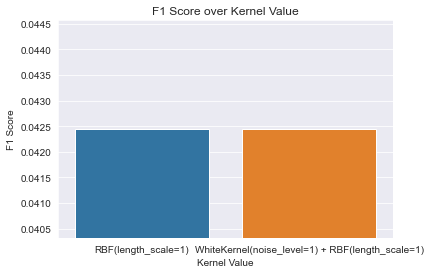

The best parameters were:
kernel: RBF(length_scale=1)


Gaussian Process Classifier Prediction Metrics:
Train Precision: 0.6666666666666666
Train Recall:    0.038338658146964855
Train F1 Score:  0.07250755287009064
Test Precision:  0.3333333333333333
Test Recall:     0.019230769230769232
Test F1 Score:   0.03636363636363637


In [12]:
# Create a list of potential parameters
gpc_params = {'kernel': [RBF(), WhiteKernel() + RBF(), DotProduct(), DotProduct()*RBF(), DotProduct()*RBF()+WhiteKernel()]}

# Train the model, and find the best model from the provided inputs
best_model, grid_search = train_model(GaussianProcessClassifier(random_state=42, copy_X_train=False), gpc_params,
                                      train_sub_X, train_sub_y)

# Display the results
display_results("Gaussian Process Classifier", best_model, grid_search, train_sub_X, train_sub_y, test_sub_X, test_sub_y)

# Save the model
save_model("Gaussian Process Classifier", grid_search)

## Support Vector Classification
*By Miguel Monares*

### Support Vector Classification Hypothesis

Support Vector Machines (SVM) are effective in high dimensional spaces. Given that our data has decent number of features, we can expect these features to be a positive attribute for the SVM's performance on the dataset. The performance of the SVM works well when the data is mostly separable, but doesn't perform well when the dataset is overlapping. Hence, we can expect that heart disease classification performance of the SVM will depend heavily on whether the features can be effectively separated. It will be important that we use an appropriate kernel in order to get the best performance from this model.

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 12.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python

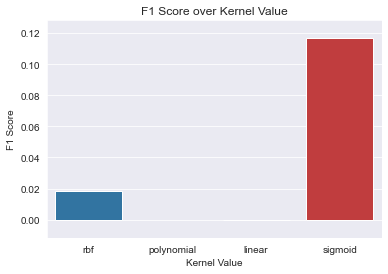

The best parameters were:
kernel: sigmoid


Svc Prediction Metrics:
Train Precision: 0.16666666666666666
Train Recall:    0.10223642172523961
Train F1 Score:  0.12673267326732673
Test Precision:  0.2777777777777778
Test Recall:     0.16025641025641027
Test F1 Score:   0.20325203252032523


In [71]:
from sklearn import svm
# Create a list of potential parameters
SVC_params = {'kernel': ['rbf', 'polynomial', 'linear', 'sigmoid']}

# Train the model, and find the best model from the provided inputs
best_model, grid_search = train_model(svm.SVC(random_state=42, ), SVC_params,
                                      train_sub_X, train_sub_y)

# Display the results
display_results("SVC", best_model, grid_search, train_sub_X, train_sub_y, test_sub_X, test_sub_y)

# Save the model
save_model("SVC", grid_search)

### Support Vector Classification Analysis

The Support Vector Classification Model performed decently compared to

 the other models. The Precision and F1 Score outscored our baseline (.15), which indicates that this model is better suited at predicting the correct status of heart disease for each patient. It has a decent recall score compared to the other models, and is a model we may consider out of the models we compare to use in practice. Out of the kernel functions we chose to use, sigmoid performed the best. This is probably because sigmoid is best suited for binary tasks, and the data is not inherently linearly separable, so the other kernels don't perform as well.

## Decision Tree Classification
*By Miguel Monares*

### Decision Tree Classification Hypothesis
*By Miguel Monares*

Decision Tree's may be a useful model for our task of heart disease classification because Decision Tree's offer interpretability and visualization that may allow us to discover insights and connections between the features that are indicative of heart disease. However, in order to maximize our performance, we need to make sure that decision tree doesn't overfit to the data, which we can influence by controlling pruning and max-depth. I expect this model will be able to find underlying connection between the features in our data, but will not be among the best.

Fitting 3 folds for each of 3 candidates, totalling 9 fits


/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/miguelmonares/.conda/envs/Group041-Sp22/lib/python3

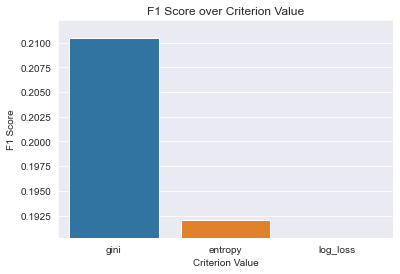

The best parameters were:
criterion: gini


Decision Tree Classifier Prediction Metrics:
Train Precision: 1.0
Train Recall:    0.9936102236421726
Train F1 Score:  0.9967948717948718
Test Precision:  0.1951219512195122
Test Recall:     0.2564102564102564
Test F1 Score:   0.221606648199446


In [72]:
from sklearn import tree
# Create a list of potential parameters
dt_params = {'criterion': ['gini', 'entropy', 'log_loss']}

# Train the model, and find the best model from the provided inputs
best_model, grid_search = train_model(tree.DecisionTreeClassifier(), dt_params,
                                      train_sub_X, train_sub_y)

# Display the results
display_results("Decision Tree Classifier", best_model, grid_search, train_sub_X, train_sub_y, test_sub_X, test_sub_y)

# Save the model
save_model("Decision Tree Classifier", grid_search)

### Decision Tree Classification Analysis

The decision tree classification model had an f1 score of .222, which outscores the baseline model f1 score (.15). Additionally, it has a higher precision score. It has a close f1 performance to that of the support vector classifier. However, the decision tree classifier has a higher recall (.256 vs .160). Since we place more importance on the value of the recall score vs precision/f1, we declare the the decision tree model is better suited for this task of prediction heart disease. Out of the criterion functions we consider for measuring the quality of splits, the gini function outperforms entropy and log_loss, which can be explained since gini facors big partitions. Gini is also faster computationally, so we prefer to use this criterion in the field.